In [1]:
import sddk
import pandas as pd
import nltk
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score


from sklearn.dummy import DummyClassifier

# Create decision tree classifier object 
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import pickle

import nltk
from nltk.util import bigrams

In [2]:
sddk.__version__ # you need this working, i.e. at least version 3.7 or higher

'3.7'

In [3]:
try:
    LIST = gpd.read_feather("../data/large_data/LIST_filtered.feather") # point out to your local version...
except:
    LIST = sddk.read_file("https://sciencedata.dk/public/27799e2d86b542dbe036bcc0abff2921/LIST_filtered_2023-01-24.feather", "gdf")

In [4]:
LIST.shape

(188896, 63)

In [5]:
# to train the model, we will work with a subset of the for which we have both the EDH and EDCS attributes
# we will call it EDHg
EDH_overlap_all = LIST[(LIST["EDH-ID"].notnull()) & (LIST["EDCS-ID"].notnull())]
EDH_overlap_all.groupby("type_of_inscription_clean").size().sort_values(ascending=False)

type_of_inscription_clean
epitaph                            21498
votive inscription                 10250
NULL                                3685
owner/artist inscription            3177
honorific inscription               2998
building/dedicatory inscription     2695
mile-/leaguestone                    846
identification inscription           820
acclamation                          285
list                                 245
defixio                              241
label                                172
military diploma                     163
elogium                              133
boundary inscription                 125
letter                               122
public legal inscription              88
seat inscription                      54
prayer                                32
private legal inscription             31
assignation inscription               13
calendar                              10
adnuntiatio                            1
dtype: int64

In [6]:
EDH_overlap = EDH_overlap_all[~EDH_overlap_all["type_of_inscription_clean"].str.contains("NULL")]

Now we can focus on some EDCS attributes (i.e. firt 28 columns) which might be good predictors of `type_of_inscription_clean` in EDH. First, look at `status_list`:

In [7]:
EDH_overlap.groupby("type_of_inscription_clean").size().sort_values(ascending=False)

type_of_inscription_clean
epitaph                            21498
votive inscription                 10250
owner/artist inscription            3177
honorific inscription               2998
building/dedicatory inscription     2695
mile-/leaguestone                    846
identification inscription           820
acclamation                          285
list                                 245
defixio                              241
label                                172
military diploma                     163
elogium                              133
boundary inscription                 125
letter                               122
public legal inscription              88
seat inscription                      54
prayer                                32
private legal inscription             31
assignation inscription               13
calendar                              10
adnuntiatio                            1
dtype: int64

In [8]:
len(EDH_overlap.groupby("type_of_inscription_clean").size().sort_values(ascending=False))

22

In [9]:
classes_sorted = [key for key in dict(EDH_overlap.groupby("type_of_inscription_clean").size().sort_values(ascending=False))]

In [10]:
# alternative, treat whole dataset as a sample
EDH_sampled = EDH_overlap

In [11]:
y = EDH_sampled["type_of_inscription_clean"].tolist()

# Build a SVM model combining `status_list` & `clean_text_interpretive_word`

next step would be to build a model combining the information from the `status_list` with an informatation from the text of the inscription (i.e. `clean_text_interpretive_word`).

In [8]:
EDH_sampled.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{},{},121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{},,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,276,Augusti/Augustae; miliaria; viri,37.454501,22.420877,

In [9]:
inscr_texts = EDH_sampled["clean_text_interpretive_word"].tolist()

The language of inscriptions is characterized by a number of standardized phrases, which often determine the type of insription. Treated separately, "Dis" and "Manibus" might be confusing, but treated as a bigram, they bear a crucial information about the type of inscription.



In [10]:
def get_bigrams_underscore(inscr_text):
    try:
        inscr_bigrams = [" ".join(el) for el in list(bigrams(inscr_text.split()))]
        inscr_bigrams_ = [bigram.replace(" ", "_") for bigram in inscr_bigrams]
    except:
        inscr_bigrams_ = []
    return inscr_bigrams_

In [11]:
EDH_bigrams_ = [get_bigrams_underscore(inscr_text) for inscr_text in inscr_texts]
EDH_bigrams_[:5]

[['Fortissimo_et',
  'et_piissimo',
  'piissimo_Caesari',
  'Caesari_domino',
  'domino_nostro',
  'nostro_Galerio',
  'Galerio_Valerio',
  'Valerio_Maximiano',
  'Maximiano_Pio',
  'Pio_Felici',
  'Felici_Invicto',
  'Invicto_Coranius',
  'Coranius_Titianus',
  'Titianus_vir',
  'vir_perfectissimus',
  'perfectissimus_praeses',
  'praeses_provinciae',
  'provinciae_veteris',
  'veteris_Epiri',
  'Epiri_numini',
  'numini_eorum',
  'eorum_dicatissimus'],
 ['Imperatori_Caesari',
  'Caesari_Marco',
  'Marco_Annio',
  'Annio_Floriano',
  'Floriano_Pio',
  'Pio_Felici',
  'Felici_Augusto',
  'Augusto_patri',
  'patri_patriae',
  'patriae_milia',
  'milia_passuum',
  'passuum_III',
  'III_Imperatori',
  'Imperatori_Caesari',
  'Caesari_Marco',
  'Marco_Aurelio',
  'Aurelio_Probo',
  'Probo_Pio',
  'Pio_Felici',
  'Felici_Augusto',
  'Augusto_milia',
  'milia_passuum',
  'passuum_II'],
 ['Tiberius_Claudius',
  'Claudius_Caesar',
  'Caesar_Augustus',
  'Augustus_Germanicus',
  'Germanicus_pon

In [12]:
# flat list of all bigrams
bigrams_list = [el for sublist in EDH_bigrams_ for el in sublist]
bigrams_list[:10]

['Fortissimo_et',
 'et_piissimo',
 'piissimo_Caesari',
 'Caesari_domino',
 'domino_nostro',
 'nostro_Galerio',
 'Galerio_Valerio',
 'Valerio_Maximiano',
 'Maximiano_Pio',
 'Pio_Felici']

In [13]:
# ok, let's list only N of the most common
bigrams_mostfreq = nltk.FreqDist(bigrams_list).most_common()
bigrams_mostfreq = [tup[0] for tup in bigrams_mostfreq]
bigrams_mostfreq[:10]

['Dis_Manibus',
 'vixit_annos',
 'votum_solvit',
 'solvit_libens',
 'libens_merito',
 'Iovi_Optimo',
 'Optimo_Maximo',
 'hic_situs',
 'situs_est',
 'tribunicia_potestate']

In [14]:
all_bigrams_freq_dict = dict(nltk.FreqDist(bigrams_list).most_common())

In [15]:
EDH_sampled["bigrams"] = EDH_bigrams_

In [16]:
len(EDH_sampled["type_of_inscription_clean"].unique())

22

In [17]:
all_bigrams_freq_dict

{'Dis_Manibus': 7844,
 'vixit_annos': 4084,
 'votum_solvit': 3335,
 'solvit_libens': 2982,
 'libens_merito': 2710,
 'Iovi_Optimo': 2413,
 'Optimo_Maximo': 2399,
 'hic_situs': 2338,
 'situs_est': 2228,
 'tribunicia_potestate': 1990,
 'Manibus_sacrum': 1865,
 'bene_merenti': 1585,
 'sibi_et': 1476,
 'Imperatori_Caesari': 1256,
 'hic_sita': 1216,
 'sita_est': 1155,
 'faciendum_curavit': 1118,
 'pro_salute': 1117,
 'terra_levis': 1111,
 'Imperator_Caesar': 1099,
 'tibi_terra': 1029,
 'sit_tibi': 999,
 'vixit_annis': 996,
 'pro_praetore': 932,
 'pontifex_maximus': 837,
 'miles_legionis': 783,
 'pontifici_maximo': 780,
 'est_sit': 749,
 'maximus_tribunicia': 708,
 'maximo_tribunicia': 706,
 'ex_voto': 701,
 'Pio_Felici': 698,
 'pater_patriae': 698,
 'patri_patriae': 687,
 'divi_Nervae': 670,
 'et_suis': 664,
 'et_I': 663,
 'Marcus_Aurelius': 656,
 'qui_vixit': 634,
 'piae_fidelis': 611,
 'Caius_Iulius': 608,
 'Marco_Aurelio': 600,
 'libens_laetus': 588,
 'decreto_decurionum': 585,
 'divi_Tra

In [193]:
N = 10
weighted_bigrams_all = []
for cat in EDH_sampled["type_of_inscription_clean"].unique():
    EDH_cat = EDH_sampled[EDH_sampled["type_of_inscription_clean"]==cat]
    bigrams_list = [el for sublist in EDH_cat["bigrams"].tolist() for el in sublist]
    cat_bigrams_freq_dict = dict(nltk.FreqDist(bigrams_list).most_common())
    weighted_bigrams = []
    for word in cat_bigrams_freq_dict.keys():
        if cat_bigrams_freq_dict[word] >= 5: # it it appears at least twice
            weighted_bigrams.append((word, cat_bigrams_freq_dict[word] / all_bigrams_freq_dict[word]))
    # choose only N of the most characteristic bigrams for given category
    weighted_bigrams = sorted(weighted_bigrams, key=lambda tup: tup[1], reverse=True)[:N]
    weighted_bigrams = [tup[0] for tup in weighted_bigrams]
    weighted_bigrams_all.extend(weighted_bigrams)

In [194]:
len(weighted_bigrams_all)

172

In [20]:
def combine_status_list_and_bigrams(el_status, el_bigrams, el_material):
    # preprocess status:
    try: el_status = eval(el_status)
    except: pass
    if isinstance(el_status, list):
        new_el_status = el_status
    elif isinstance(el_status, str):
        new_el_status = [el_status]
    else: 
        new_el_status = []
    new_el_status = [el.replace(" ", "_") for el in new_el_status]
    # preprocess material:
    if el_material is None:
        el_material = []    
    else:
        el_material = el_material.partition(": ")[0] # 
        el_material = el_material.split(", ")
        el_material = [el.replace(" ", "_").replace("?", "") for el in el_material]
    # combine status, bigrams and material
    new_el = new_el_status + el_bigrams + el_material
    new_el = " ".join(new_el)
    return new_el, new_el_status, el_material

In [21]:
status_bigrams_list = []
status_list = []
material_list = []
for el_status, el_bigrams, el_material in zip(EDH_sampled["status_list"].tolist(), EDH_sampled["bigrams"].tolist(), EDH_sampled["Material"].tolist()):
    new_el, new_status, el_material = combine_status_list_and_bigrams(el_status, el_bigrams, el_material)
    status_bigrams_list.append(new_el)
    status_list.append(new_status)
    material_list.extend(el_material)

In [3]:
materials_freqdist = nltk.FreqDist(material_list).most_common()
len(materials_freqdist)

NameError: name 'nltk' is not defined

In [23]:
materials_freqdist

[('lapis', 22042),
 ('opus_figlinae', 2247),
 ('aes', 796),
 ('plumbum', 528),
 ('lignum', 289),
 ('argentum', 289),
 ('aurum', 82),
 ('vitrum', 63),
 ('ferrum', 60),
 ('tectorium', 58),
 ('musivum', 27),
 ('steatitis', 11),
 ('os', 10),
 ('cyprum', 6),
 ('gemma', 4),
 ('rupes', 4),
 ('corium', 1),
 ('sucineus', 1)]

In [2]:
N = 20
materials_N = [tup[0] for tup in materials_freqdist[:N]]
len(materials_N)

NameError: name 'materials_freqdist' is not defined

In [25]:
status_bigrams_list[:10]

['Augusti/Augustae litterae_erasae ordo_equester tituli_honorarii tria_nomina Fortissimo_et et_piissimo piissimo_Caesari Caesari_domino domino_nostro nostro_Galerio Galerio_Valerio Valerio_Maximiano Maximiano_Pio Pio_Felici Felici_Invicto Invicto_Coranius Coranius_Titianus Titianus_vir vir_perfectissimus perfectissimus_praeses praeses_provinciae provinciae_veteris veteris_Epiri Epiri_numini numini_eorum eorum_dicatissimus',
 'Augusti/Augustae miliaria viri Imperatori_Caesari Caesari_Marco Marco_Annio Annio_Floriano Floriano_Pio Pio_Felici Felici_Augusto Augusto_patri patri_patriae patriae_milia milia_passuum passuum_III III_Imperatori Imperatori_Caesari Caesari_Marco Marco_Aurelio Aurelio_Probo Probo_Pio Pio_Felici Felici_Augusto Augusto_milia milia_passuum passuum_II lapis',
 'Augusti/Augustae leges viri Tiberius_Claudius Claudius_Caesar Caesar_Augustus Augustus_Germanicus Germanicus_pontifex pontifex_maximus maximus_tribunicia tribunicia_potestate potestate_VIIII VIIII_imperator impe

In [26]:
el_status = EDH_sampled["status_list"].tolist()[0]

In [27]:
status_bigrams_list[0]

'Augusti/Augustae litterae_erasae ordo_equester tituli_honorarii tria_nomina Fortissimo_et et_piissimo piissimo_Caesari Caesari_domino domino_nostro nostro_Galerio Galerio_Valerio Valerio_Maximiano Maximiano_Pio Pio_Felici Felici_Invicto Invicto_Coranius Coranius_Titianus Titianus_vir vir_perfectissimus perfectissimus_praeses praeses_provinciae provinciae_veteris veteris_Epiri Epiri_numini numini_eorum eorum_dicatissimus'

In [28]:
status_list_flat = [el for sublist in status_list for el in sublist]
status_N = [tup[0] for tup in nltk.FreqDist(status_list_flat).most_common(100)] ### we had 228 in total
status_N[:10]

['viri',
 'tituli_sepulcrales',
 'tria_nomina',
 'tituli_sacri',
 'mulieres',
 'milites',
 'nomen_singulare',
 'Augusti/Augustae',
 'tituli_operum',
 'tituli_fabricationis']

In [29]:
len(status_N)

37

# Experiments with one list of the most frequent bigrams

In [34]:
vocab = status_N + bigrams_mostfreq[:100] + materials_N

In [33]:
subset_size = 3000 # len(y)
vectorizer = TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab)
X = vectorizer.fit_transform(status_bigrams_list[:subset_size])
X.todense().shape
X_train, X_test, y_train, y_test = train_test_split(X[:subset_size], y[:subset_size], test_size=0.1, random_state=1)

In [73]:
def train_svm(X, y):
    """
    Create and train the Support Vector Machine.
    """
    svm = SVC(C=1000000.0, gamma='auto', kernel='rbf', probability=True)
    svm.fit(X, y)
    return svm

In [74]:
%%time
svm = train_svm(X_train, y_train)

CPU times: user 2.46 s, sys: 15 ms, total: 2.48 s
Wall time: 2.48 s


In [75]:
print(svm.score(X_test, y_test))

0.8333333333333334


In [38]:
# only where the predictor is present
predictors_present = [np.any(el) for el in X_test.todense()]
# check the performance on datapoints for which we have something in the "status_list"
svm.score(X_test.todense()[predictors_present], np.array(y_test)[predictors_present])

0.8617021276595744

In [39]:
svm.classes_

array(['acclamation', 'assignation inscription', 'boundary inscription',
       'building/dedicatory inscription', 'defixio', 'elogium', 'epitaph',
       'honorific inscription', 'identification inscription', 'label',
       'letter', 'list', 'mile-/leaguestone', 'military diploma',
       'owner/artist inscription', 'prayer', 'private legal inscription',
       'public legal inscription', 'seat inscription',
       'votive inscription'], dtype='<U31')

In [40]:
test_pred_probs = [(svm.classes_[np.argmax(pred)], pred[np.argmax(pred)], real) for pred, real in zip(svm.predict_proba(X_test), y_test)]
test_pred_probs[:20]

[('epitaph', 0.5701242436459757, 'epitaph'),
 ('epitaph', 0.9621257717863589, 'epitaph'),
 ('building/dedicatory inscription', 0.3946471383724565, 'epitaph'),
 ('owner/artist inscription',
  0.6050564118603547,
  'identification inscription'),
 ('votive inscription', 0.9557391731241968, 'votive inscription'),
 ('epitaph', 0.9432540245204908, 'epitaph'),
 ('defixio', 0.4921905918450132, 'defixio'),
 ('votive inscription', 0.9571153789522941, 'votive inscription'),
 ('epitaph', 0.9187064590820762, 'epitaph'),
 ('owner/artist inscription', 0.6617075497938236, 'owner/artist inscription'),
 ('owner/artist inscription', 0.6765519220011015, 'owner/artist inscription'),
 ('votive inscription', 0.6218476701820005, 'votive inscription'),
 ('epitaph', 0.5051037826496995, 'votive inscription'),
 ('epitaph', 0.9231800137716382, 'epitaph'),
 ('owner/artist inscription', 0.6717331047636865, 'owner/artist inscription'),
 ('mile-/leaguestone', 0.8268432464997768, 'mile-/leaguestone'),
 ('epitaph', 0.93

In [41]:
for threshold in [thres / 100 for thres in range(30, 100, 5)]:
    above_threshold = [tup for tup in test_pred_probs if tup[1] >= threshold]
    correct_count = len([tup for tup in above_threshold if tup[0] == tup[2]]) # correct total
    correct_proportion = correct_count / len(above_threshold)# correct ratio 
    proportion = len(above_threshold) / len(test_pred_probs)
    print("prob. threshold: {0}, proportion of inscr.: {1}, correctly classified: {2}".format(threshold, proportion, correct_proportion))

prob. threshold: 0.3, proportion of inscr.: 0.99, correctly classified: 0.8484848484848485
prob. threshold: 0.35, proportion of inscr.: 0.96, correctly classified: 0.8506944444444444
prob. threshold: 0.4, proportion of inscr.: 0.92, correctly classified: 0.8731884057971014
prob. threshold: 0.45, proportion of inscr.: 0.9066666666666666, correctly classified: 0.8786764705882353
prob. threshold: 0.5, proportion of inscr.: 0.8966666666666666, correctly classified: 0.8810408921933085
prob. threshold: 0.55, proportion of inscr.: 0.8566666666666667, correctly classified: 0.8988326848249028
prob. threshold: 0.6, proportion of inscr.: 0.76, correctly classified: 0.9385964912280702
prob. threshold: 0.65, proportion of inscr.: 0.73, correctly classified: 0.9497716894977168
prob. threshold: 0.7, proportion of inscr.: 0.69, correctly classified: 0.9516908212560387
prob. threshold: 0.75, proportion of inscr.: 0.6633333333333333, correctly classified: 0.9547738693467337
prob. threshold: 0.8, proport

# Testing different models

In [45]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline 


from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler

In [103]:
raw_features = status_N + bigrams_mostfreq[:100] + materials_N

In [104]:
vectorizer = TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)
X = vectorizer.fit_transform(status_bigrams_list)
X.todense().shape

(46171, 155)

### Dummy

In [274]:
# build a dummy classifier
dummy = DummyClassifier(strategy='stratified', random_state=1)
# build a pipeline with it
pipeline = Pipeline(steps=[("vectorizer", vectorizer), ("classifier", dummy)]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.30568086 0.31642284 0.28346112 0.30191908 0.29962008]
0.30142079524410104


For model evaluation, we use `f1_weighted` score. In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

### SVC


In [237]:
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:2000] + weighted_bigrams_all))

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", SVC(C=1000000.0, gamma='auto', kernel='rbf', probability=True))
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.8441247  0.81207956 0.82703795 0.79978009 0.78690697]
0.8139858510323448


### Decision Tree

In [238]:
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:2000] + weighted_bigrams_all))
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", DecisionTreeClassifier(random_state=1, max_depth=None))
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.81414832 0.78747084 0.80272851 0.79390465 0.78977883]
0.7976062287866688


### Random forest classifier

Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

G. Louppe, “Understanding Random Forests: From Theory to Practice”, PhD Thesis, U. of Liege, 2014.

In [249]:
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:5000])) # + weighted_bigrams_all))
#raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:1000] + weighted_bigrams_all))
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", RandomForestClassifier(random_state=1, n_jobs=-1))
])

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.8249471  0.82458837 0.83614358 0.82957414 0.82168963]
0.8273885625338251


### Extremely randomized trees
P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006.

In [278]:
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:10000])) # + weighted_bigrams_all))

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", ExtraTreesClassifier(random_state=1, n_jobs=-1))
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.82957365 0.82986656 0.82312102 0.83080767 0.83962222]
0.8305982227473967


### K-Nearest Neighbor Classifier

In [250]:
from sklearn.neighbors import KNeighborsClassifier

In [263]:
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:10000])) # + weighted_bigrams_all))

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", KNeighborsClassifier(n_neighbors=3, weights="distance", n_jobs=-1))
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.66595748 0.68311257 0.67430162 0.7029221  0.70797774]
0.686854303182178


### Logistic Regression

In [265]:
from sklearn.linear_model import LogisticRegression

In [318]:
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:10000])) # + weighted_bigrams_all))

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", LogisticRegression(penalty="l2", C=1000, n_jobs=-1))
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.83827197 0.8500859  0.82813589 0.83752569 0.8182156 ]
0.8344470094033852


### Multinomial Naive Bayes

In [307]:
from sklearn.naive_bayes import MultinomialNB

In [316]:
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]
raw_features = list(set(status_N + materials_N + bigrams_mostfreq[:10000])) # + weighted_bigrams_all))

pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=raw_features, lowercase=False)),
    ("classifier", MultinomialNB())
]) 

#  pipeline parameters for testing
N = 5000 # number of observations
# Create k-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# Conduct k-fold cross-validation 
cv_results = cross_val_score(
    pipeline, # Pipeline
    status_bigrams_list[:N], # Feature matrix
    y[:N], # Target vector 
    cv=kf, # Cross-validation technique 
    scoring="f1_weighted", # Loss function
    n_jobs=-1) # Use all CPU scores
print(cv_results)
print(cv_results.mean())

[0.76537122 0.74506975 0.74200149 0.75235346 0.75308754]
0.7515766918484228


## Model selection

In [509]:
vocabs = [
    status_N,
    status_N + materials_N,
    list(set(status_N + materials_N + bigrams_mostfreq[:100])),
    list(set(status_N + materials_N + bigrams_mostfreq[:1000])),
    list(set(status_N + materials_N + bigrams_mostfreq[:10000]))]

In [510]:
LR = LogisticRegression(penalty="l2", n_jobs=-1)
SVM = SVC(gamma='auto', kernel='rbf', probability=True)
MNB = MultinomialNB()
RF = RandomForestClassifier(n_jobs=-1)
ET = ExtraTreesClassifier(n_jobs=-1)

In [513]:
pipeline = Pipeline(steps=[
    ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocabs[4], lowercase=False)),
    ("classifier", LR)
]) 

# Create space of candidate values 
search_space = [
    {"classifier" : [LR],
    "classifier__C" : [1, 1000, 10000]},
    {"classifier" : [SVM],
    "classifier__C" : [1, 1000, 10000]},
    {"classifier" : [MNB]},
    {"classifier" : [RF],
     "classifier__n_estimators" : [10, 100, 1000]},
    {"classifier" : [ET],
    "classifier__n_estimators" : [10, 100, 1000]}, 
     ]

# Create grid search 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clf = GridSearchCV(pipeline,
                   search_space,
                   cv=kf, 
                   verbose=0, 
                   scoring="f1_weighted",
                   n_jobs=-1)

# Fit grid search 
N = 5000
best_model = clf.fit(
    status_bigrams_list[:N], # Feature matrix
    y[:N])

In [514]:
classifiers_short = ["LR"]*3 + ["SVM"] * 3 + ["MNB"] + ["RF"] * 3 + ["ET"] * 3 

In [515]:
clf_results = pd.DataFrame(clf.cv_results_["params"])
clf_results["avg. score"] = clf.cv_results_["mean_test_score"]
clf_results["classifier"] = classifiers_short
clf_results

,classifier,classifier__C,classifier__n_estimators,avg. score
0,LR,1.0,NaN,0.808297
1,LR,1000.0,NaN,0.831937
2,LR,10000.0,NaN,0.830611
3,SVM,1.0,NaN,0.310482
4,SVM,1000.0,NaN,0.760049
5,SVM,10000.0,NaN,0.828478
6,MNB,NaN,NaN,0.750174
7,RF,NaN,10.0,0.815809
8,RF,NaN,100.0,0.825325
9,RF,NaN,1000.0,0.826737


In [527]:
print(clf_results.to_latex(index=False, na_rep=""))

\begin{tabular}{lrrr}
\toprule
classifier &  classifier\_\_C &  classifier\_\_n\_estimators &  avg. score \\
\midrule
        LR &            1.0 &                           &    0.808297 \\
        LR &         1000.0 &                           &    0.831937 \\
        LR &        10000.0 &                           &    0.830611 \\
       SVM &            1.0 &                           &    0.310482 \\
       SVM &         1000.0 &                           &    0.760049 \\
       SVM &        10000.0 &                           &    0.828478 \\
       MNB &                &                           &    0.750174 \\
        RF &                &                      10.0 &    0.815809 \\
        RF &                &                     100.0 &    0.825325 \\
        RF &                &                    1000.0 &    0.826737 \\
        ET &                &                      10.0 &    0.822891 \\
        ET &                &                     100.0 &    0.831064 \\
      

In [511]:
best_model.best_estimator_.get_params()["classifier"]

LogisticRegression(C=10000, n_jobs=-1)

In [562]:
vocabs_tups = [
    ("status", status_N),
    ("status+material", status_N + materials_N),
    ("status+material+100bigrams", list(set(status_N + materials_N + bigrams_mostfreq[:100]))),
    ("status+material+100Obigrams", list(set(status_N + materials_N + bigrams_mostfreq[:1000]))),
    ("status+material+10000bigrams", list(set(status_N + materials_N + bigrams_mostfreq[:10000])))
]

def make_cv(pipeline, N=5000, splits=5):
    N = N # number of observations
    # Create k-Fold cross-validation
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
    # Conduct k-fold cross-validation 
    cv_results = cross_val_score(
        pipeline, # Pipeline
        status_bigrams_list[:N], # Feature matrix
        y[:N], # Target vector 
        cv=kf, # Cross-validation technique 
        scoring="f1_weighted", # Loss function
        n_jobs=-1) # Use all CPU scores
    return cv_results


features_tests = []
for vocab_tup in vocabs_tups:
    ET_pipeline = Pipeline(steps=[
        ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab_tup[1], lowercase=False)),
        ("classifier", LR)
    ]) 
    ET_cv_results = make_cv(ET_pipeline)
    features_test = ({"features" : vocab_tup[0], "avg. score" : ET_cv_results.mean()})
    print(features_test)
    features_tests.append(features_test)

{'features': 'status', 'avg. score': 0.7244000248255664}
{'features': 'status+material', 'avg. score': 0.7341987251815294}
{'features': 'status+material+100bigrams', 'avg. score': 0.7875156417891627}
{'features': 'status+material+100Obigrams', 'avg. score': 0.8128055118209364}
{'features': 'status+material+10000bigrams', 'avg. score': 0.8319369175400082}


In [563]:
# LR fully dataset
pipeline = Pipeline(steps=[
        ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocabs_tups[4][1], lowercase=False)),
        ("classifier", LogisticRegression(penalty="l2", n_jobs=-1, C=10000))]) 
LR_cv_results = make_cv(pipeline, N=len(y), splits=10)
features_test = ({"N" : len(y), "avg. $F_1$" : LR_cv_results.mean()})
print(features_test)

{'N': 46171, 'avg. $F_1$': 0.869932555305039}


In [564]:
# ET fully dataset
pipeline = Pipeline(steps=[
        ("vectorizer", TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocabs_tups[4][1], lowercase=False)),
        ("classifier", ExtraTreesClassifier(n_jobs=-1, n_estimators=100))]) 
cv_results = make_cv(pipeline, N=len(y), splits=10)
features_test = ({"N" : len(y), "avg. $F_1$" : cv_results.mean()})
print(features_test)

{'N': 46171, 'avg. $F_1$': 0.8783781087377566}


In [565]:
LR_cv_results

array([0.87797476, 0.87309657, 0.87377532, 0.8731408 , 0.8664169 ,
       0.86816687, 0.87009752, 0.86284565, 0.86940823, 0.86440294])

In [566]:
scipy.stats.ttest_ind(LR_cv_results, cv_results)

Ttest_indResult(statistic=-4.234266514438035, pvalue=0.0004987813281702424)

# ET - Main training 

In [567]:
#raw_features = status_N + materials_N + bigrams_mostfreq[:1000]
vocab = list(set(status_N + materials_N + bigrams_mostfreq[:10000])) # + weighted_bigrams_all))

vectorizer =  TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab, lowercase=False)
X = vectorizer.fit_transform(status_bigrams_list)

classifier = ExtraTreesClassifier(random_state=1, n_jobs=-1, n_estimators=100)

In [568]:
# Create training and test set 
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [569]:
len(np.unique(target_test))

21

In [571]:
target_predicted = classifier.fit(features_train, target_train).predict(features_test)

In [570]:
len(np.unique(target_predicted))

20

In [601]:
model_path = '../data/large_data/et_model_v1.0.sav'
pickle.dump(classifier, open(model_path, 'wb'))
vectorizer_path= '../data/large_data/et_vectorizer_v1.0.sav'
pickle.dump(vectorizer, open(vectorizer_path, "wb"))

In [573]:
# accuracy
classifier.score(features_test, target_test)

0.8867475097444781

In [574]:
f1_score(target_test, target_predicted, average="weighted")

0.8784008688841075

In [575]:
test_pred_probs = [(classifier.classes_[np.argmax(pred)], pred[np.argmax(pred)], real) for pred, real in zip(classifier.predict_proba(features_test), target_test)]
test_pred_probs[:20]

[('votive inscription', 0.927, 'building/dedicatory inscription'),
 ('votive inscription', 0.9636963696369635, 'votive inscription'),
 ('votive inscription', 1.0, 'votive inscription'),
 ('epitaph', 1.0, 'epitaph'),
 ('epitaph', 1.0, 'epitaph'),
 ('votive inscription', 0.9000000000000008, 'votive inscription'),
 ('epitaph', 1.0, 'epitaph'),
 ('votive inscription', 0.3346691729323308, 'building/dedicatory inscription'),
 ('epitaph', 0.4293233082706769, 'epitaph'),
 ('honorific inscription', 0.89, 'honorific inscription'),
 ('epitaph', 1.0, 'epitaph'),
 ('epitaph', 1.0, 'epitaph'),
 ('votive inscription', 0.8666666666666651, 'votive inscription'),
 ('epitaph', 0.91, 'epitaph'),
 ('epitaph', 1.0, 'epitaph'),
 ('epitaph', 1.0, 'epitaph'),
 ('building/dedicatory inscription',
  0.37555886736214533,
  'building/dedicatory inscription'),
 ('epitaph', 1.0, 'epitaph'),
 ('votive inscription', 1.0, 'votive inscription'),
 ('epitaph', 1.0, 'epitaph')]

In [612]:
test_results = []
for threshold in [thres / 100 for thres in range(
    30, 100, 5)]:
    above_threshold = [tup for tup in test_pred_probs if tup[1] >= threshold]
    f1 = f1_score([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], average="weighted")
    accuracy = accuracy_score([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], normalize=True)
    proportion = len(above_threshold) / len(test_pred_probs)
    test_results.append({"threshold (=/>)" : threshold, "proportion" : np.round(proportion, 2), "N" : len(above_threshold), "$F_1(w)$" : f1 ,"accuracy" : accuracy})
test_results_df = pd.DataFrame(test_results)
test_results_df

,threshold (=/>),proportion,N,$F_1(w)$,accuracy
0,0.30,1.00,4600,0.880791,0.888696
1,0.35,0.99,4571,0.884897,0.892802
2,0.40,0.96,4448,0.897102,0.905800
3,0.45,0.91,4225,0.923481,0.929467
4,0.50,0.89,4123,0.935463,0.940092
5,0.55,0.87,4027,0.945704,0.949839
6,0.60,0.85,3936,0.952090,0.955539
7,0.65,0.83,3853,0.957309,0.960550
8,0.70,0.81,3755,0.962801,0.965379
9,0.75,0.79,3653,0.965969,0.968519


In [588]:
print(test_results_df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 threshold (=/>) &  proportion &     N &  \$F\_1(w)\$ &  accuracy \\
\midrule
            0.40 &        0.96 &  4448 &  0.897102 &  0.905800 \\
            0.45 &        0.91 &  4225 &  0.923481 &  0.929467 \\
            0.50 &        0.89 &  4123 &  0.935463 &  0.940092 \\
            0.55 &        0.87 &  4027 &  0.945704 &  0.949839 \\
            0.60 &        0.85 &  3936 &  0.952090 &  0.955539 \\
            0.65 &        0.83 &  3853 &  0.957309 &  0.960550 \\
            0.70 &        0.81 &  3755 &  0.962801 &  0.965379 \\
            0.75 &        0.79 &  3653 &  0.965969 &  0.968519 \\
            0.80 &        0.76 &  3526 &  0.970297 &  0.972490 \\
            0.85 &        0.70 &  3253 &  0.978090 &  0.979096 \\
            0.90 &        0.67 &  3082 &  0.979371 &  0.980208 \\
            0.95 &        0.60 &  2762 &  0.981634 &  0.982259 \\
\bottomrule
\end{tabular}



In [589]:
N_labels = 10
matrix = confusion_matrix(target_test, target_predicted, labels=classes_sorted[:N_labels], normalize="true")
dataframe = pd.DataFrame(matrix, index=classes_sorted[:N_labels], columns=classes_sorted[:N_labels])

In [ ]:
N_labels = 10
matrix = confusion_matrix(target_test, target_predicted, labels=classes_sorted[:N_labels], normalize="true")
dataframe = pd.DataFrame(matrix, index=classes_sorted[:N_labels], columns=classes_sorted[:N_labels])

In [590]:
# row sum:
dataframe.iloc[0].sum()

1.0

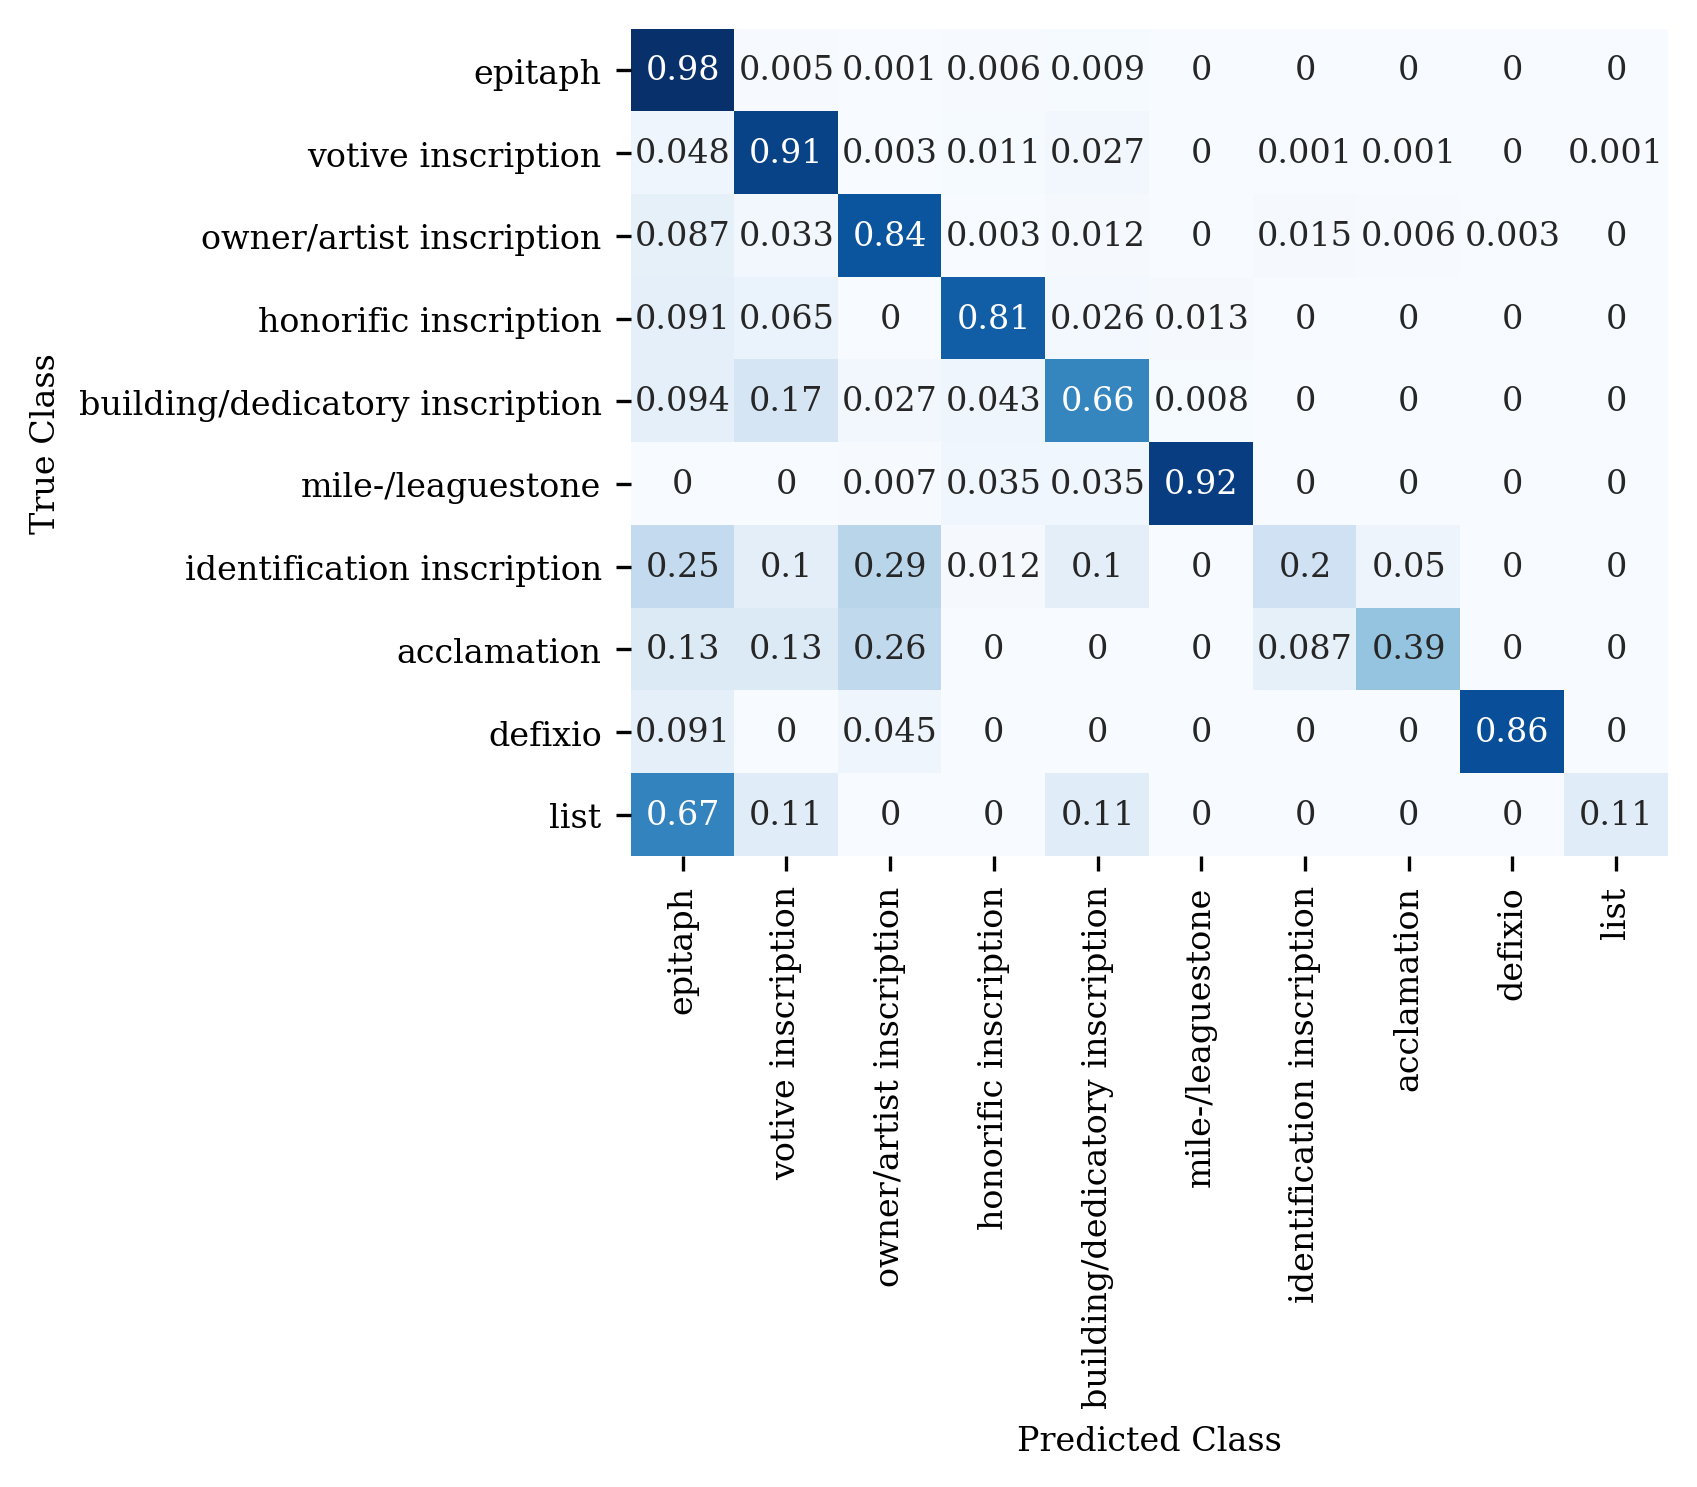

In [591]:
N_labels = 10
matrix = confusion_matrix(target_test, target_predicted, labels=classes_sorted[:N_labels], normalize="true")
dataframe = pd.DataFrame(matrix, index=classes_sorted[:N_labels], columns=classes_sorted[:N_labels])

plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe.round(3), annot=True, cbar=None, cmap="Blues", ax=ax) 

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

In [603]:
N_labels = 10
threshold = 0.6
above_threshold = [tup for tup in test_pred_probs if tup[1] >= threshold]
matrix = confusion_matrix([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], labels=classes_sorted[:N_labels], normalize="true")
dataframe = pd.DataFrame(matrix, index=classes_sorted[:N_labels], columns=classes_sorted[:N_labels])

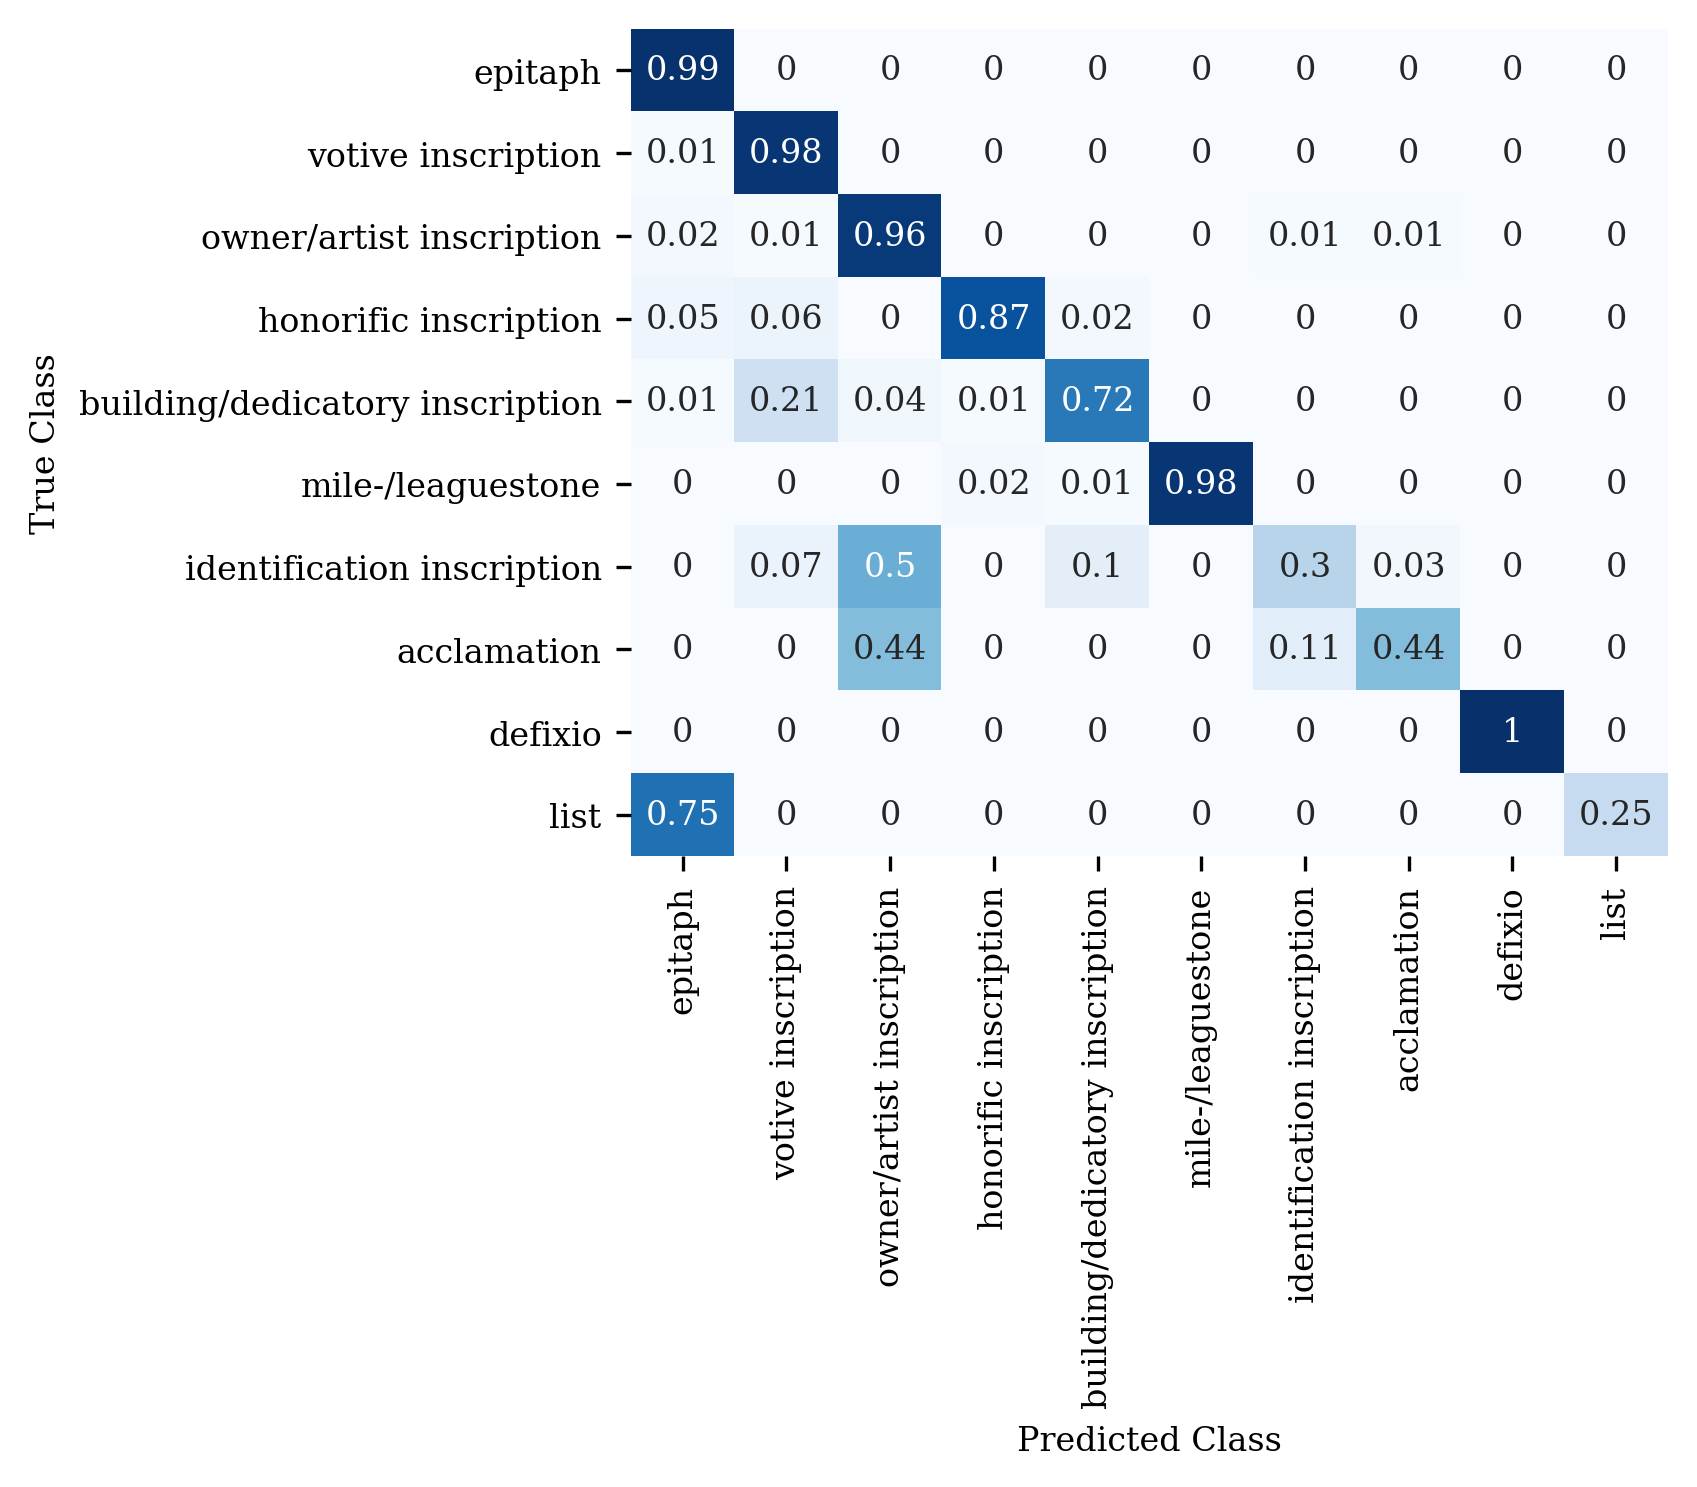

In [606]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe.round(2), annot=True, cbar=None, cmap="Blues", fmt='g', ax=ax) 
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

In [608]:
# to save figures
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/LIRE/CHR2021/"

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [609]:
s.write_file(figpath + "precision_table_06.png", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/LIRE/CHR2021/precision_table_06.png"
